In [15]:
import os
import time
from datetime import date
from pathlib import Path
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import WebDriverException
import matplotlib.pyplot as plt

from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.chrome.options import Options as ChromeOptions

In [16]:
DATA_DIR = Path("D:/Automation/Inventory Value")
DATA_DIR.mkdir(parents=True, exist_ok=True)
CSV_PATH = DATA_DIR / "cases_prices.csv"

# List of items to scrape
ITEMS = [
    ("https://steamcommunity.com/market/listings/730/Dreams%20%26%20Nightmares%20Case", "Dreams & Nightmares Case", 1),
    ("https://steamcommunity.com/market/listings/730/Revolution%20Case", "Revolution Case", 2),
    ("https://steamcommunity.com/market/listings/730/Kilowatt%20Case", "Kilowatt Case", 3),
    ("https://steamcommunity.com/market/listings/730/Fracture%20Case", "Fracture Case", 1),
    ("https://steamcommunity.com/market/listings/730/Recoil%20Case", "Recoil Case", 2),
    ("https://steamcommunity.com/market/listings/730/Gallery%20Case", "Gallery Case", 3),
    ("https://steamcommunity.com/market/listings/730/CS20%20Case", "CS20 Case", 1),
    ("https://steamcommunity.com/market/listings/730/USP-S%20%7C%20Tropical%20Breeze%20%28Minimal%20Wear%29", "USP-S | Tropical Breeze", 2),
    ("https://steamcommunity.com/market/listings/730/SSG%2008%20%7C%20Acid%20Fade%20%28Factory%20New%29", "SSG 08 | Acid Fade", 3),
    ("https://steamcommunity.com/market/listings/730/Clutch%20Case", "Clutch Case", 1),
    ("https://steamcommunity.com/market/listings/730/SG%20553%20%7C%20Damascus%20Steel%20(Field-Tested)", "SG 553 | Damascus Steel", 2),
    ("https://steamcommunity.com/market/listings/730/Five-SeveN%20%7C%20Sky%20Blue%20%28Minimal%20Wear%29", "Five-SeveN | Sky Blue", 3),
    ("https://steamcommunity.com/market/listings/730/Snakebite%20Case", "Snakebite Case", 1),
]

In [17]:
def create_driver(headless: bool = True) -> webdriver.Chrome:
    """Create and return a configured Chrome WebDriver instance."""
    chrome_driver_path = r"D:\Programs\Chrome\chromedriver-win64\chromedriver.exe"
    chrome_binary_path = r"D:\Programs\Chrome\chrome-win64\chrome.exe"

    chrome_options = ChromeOptions()
    if chrome_binary_path:
        chrome_options.binary_location = chrome_binary_path
    chrome_options.add_argument("--log-level=3")
    chrome_options.add_experimental_option("excludeSwitches", ["enable-logging"])
    if headless:
        chrome_options.add_argument("--headless=new")

    try:
        service = ChromeService(executable_path=chrome_driver_path) if chrome_driver_path else ChromeService()
        driver = webdriver.Chrome(service=service, options=chrome_options)
        print("[/] Using Chrome WebDriver")
        return driver
    except WebDriverException as e:
        print(f"[X] Failed to initialize WebDriver: {e}")
        raise

In [18]:
def scrape_price(driver: webdriver.Chrome, url: str) -> float | None:
    """Scrape the current Steam market price from a listing page."""
    try:
        driver.get(url)
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, "market_commodity_orders_header_promote"))
        )
        spans = driver.find_elements(By.CLASS_NAME, "market_commodity_orders_header_promote")
        if spans:
            price_text = spans[-1].text.strip().replace("$", "")
            try:
                return float(price_text)
            except ValueError:
                print(f"[!] Invalid price format on {url}")
                return None
        print(f"[!] No price found on {url}")
        return None
    except Exception as e:
        print(f"[!] Error scraping {url}: {e}")
        return None


In [ ]:
def get_prices(output_csv: Path) -> pd.DataFrame:
    """Scrape all items and save results to CSV."""
    results: list[tuple[str, float, int]] = []

    driver = create_driver(headless=False)
    try:
        for url, name, qty in ITEMS:
            print(f"[*] Scraping {name} ...", end=" ")
            price = scrape_price(driver, url)
            if price:
                results.append((name, price, qty))
                print(f"[/] ${price:.2f}")
            else:
                print("[X] Failed")
    finally:
        driver.quit()

    df = pd.DataFrame(results, columns=["item", "price", "quantity"])
    df["price_after_fee"] = df["price"] * 0.88
    df["total_after_fee"] = df["price_after_fee"] * df["quantity"]
    df["date"] = pd.Timestamp.now().normalize()

    df.to_csv(output_csv, index=False)
    print(f"[/] Saved {len(df)} items to {output_csv}")
    return df

In [20]:
def plot_skin_contributions(df: pd.DataFrame, output_dir: Path) -> None:
    """Create and save a pie chart of total values."""
    if df.empty:
        print("[!] No data to plot.")
        return

    df_sorted = df.sort_values(by="total_after_fee", ascending=False)
    names = df_sorted["item"]
    totals = df_sorted["total_after_fee"]
    grand_total = totals.sum()

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie( # type: ignore
        totals,
        labels=names, # type: ignore
        autopct=lambda pct: f"{pct:.1f}%",
        startangle=0,
        wedgeprops=dict(width=0.3)
    )
    plt.title("Skin Contribution to Grand Total")
    plt.text(0, -1.25, f"Grand Total: {grand_total:.2f}$", ha="center", fontsize=12)
    plt.legend(wedges, names, title="Skins", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    current_time = date.today()
    output_path = output_dir / f"skin_contribution_{current_time.month}-{current_time.day}.png"
    plt.savefig(output_path, bbox_inches="tight")
    print(f"[/] Graph saved to {output_path}")

In [ ]:
def main() -> None:
    """Run the scraping and plotting workflow."""
    df = get_prices(CSV_PATH)
    plot_skin_contributions(df, DATA_DIR)
    print("[/] All tasks completed successfully.")


if __name__ == "__main__":
    main()

FigureWidget({
    'data': [{'cells': {'values': [[], [], [], [], []]},
              'domain': {'x': [0.0, 1.0], 'y': [0.625, 1.0]},
              'header': {'values': ['Item', 'Price', 'Quantity', 'Price after fee', 'Total after fee']},
              'type': 'table',
              'uid': '9c5e4245-60ce-4ec8-a5c7-4cbc48c3f76d'},
             {'domain': {'x': [0.0, 1.0], 'y': [0.0, 0.375]},
              'labels': [],
              'marker': {'line': {'color': 'black', 'width': 2}},
              'textinfo': 'percent+label',
              'type': 'pie',
              'uid': '829a3c32-578d-4ec3-be89-d84513d72225',
              'values': []}],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Steam Market Item Prices',
                                'x': 0.5,
                                'xanchor': 'center',
                                'xref': 'paper',
                               

[/] Using Chrome WebDriver
[/] Saved: Dreams & Nightmares Case, 1.89, 1
[/] Saved: Revolution Case, 0.57, 1
[/] Saved: Kilowatt Case, 0.52, 4
[/] Saved: Fracture Case, 0.74, 1
[/] Saved: Recoil Case, 0.43, 6
[/] Saved: Gallery Case, 1.41, 20
[/] Saved: CS20 Case, 1.47, 1
[/] Saved: USP-S | Tropical Breeze, 3.77, 1
[/] Saved: SSG 08 | Acid Fade, 3.39, 1
[/] Saved: Clutch Case, 1.15, 1
[/] Saved: SG 553 | Damascus Steel, 0.77, 1
[/] Saved: Five-SeveN | Sky Blue, 0.43, 1
[/] Saved: Snakebite Case, 0.81, 1
graph saved to  D:\Automation\Inventory Value\


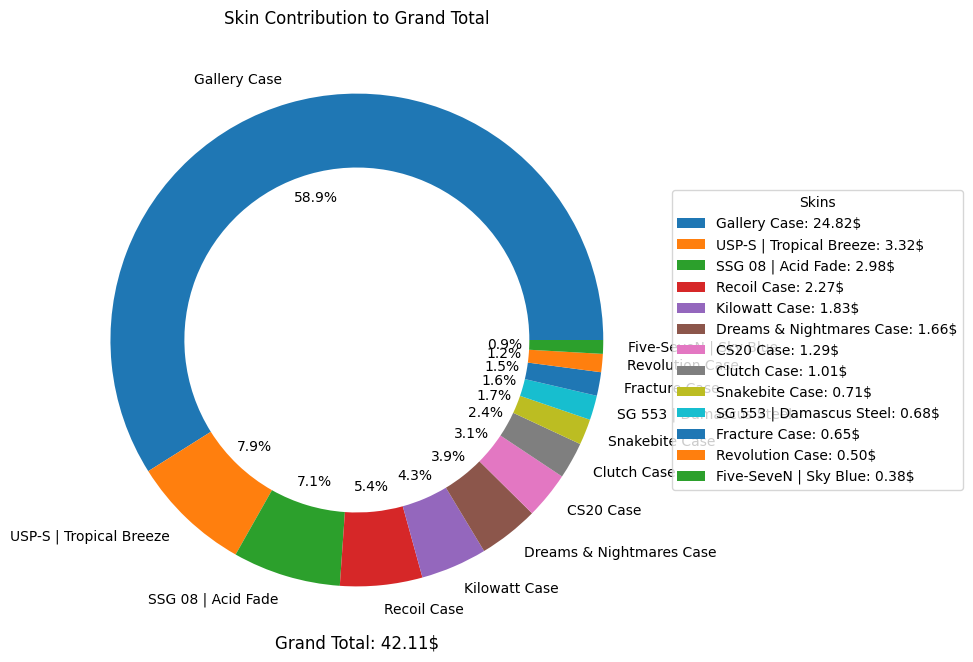

In [ ]:
# import time
# import csv
# from selenium import webdriver
# from selenium.webdriver.chrome.service import Service
# from selenium.webdriver.common.by import By
# from selenium.webdriver.chrome.options import Options
# from selenium.common.exceptions import WebDriverException
# import matplotlib.pyplot as plt
# import sys
# from datetime import date
# import shutil
# import pandas as pd
# import os

# first: bool = True;
    
# def get_prices(filePath):
#     with open(filePath, mode="w", newline="", encoding="utf-8") as file:
#         pass

#     get_price("https://steamcommunity.com/market/listings/730/Dreams%20%26%20Nightmares%20Case","Dreams & Nightmares Case", 1)
#     get_price("https://steamcommunity.com/market/listings/730/Revolution%20Case", "Revolution Case" ,1)
#     get_price("https://steamcommunity.com/market/listings/730/Kilowatt%20Case", "Kilowatt Case", 4)
#     get_price("https://steamcommunity.com/market/listings/730/Fracture%20Case", "Fracture Case", 1)
#     get_price("https://steamcommunity.com/market/listings/730/Recoil%20Case", "Recoil Case", 6)
#     get_price("https://steamcommunity.com/market/listings/730/Gallery%20Case", "Gallery Case", 20)
#     get_price("https://steamcommunity.com/market/listings/730/CS20%20Case","CS20 Case", 1)
#     get_price("https://steamcommunity.com/market/listings/730/USP-S%20%7C%20Tropical%20Breeze%20%28Minimal%20Wear%29","USP-S | Tropical Breeze" ,1)
#     get_price("https://steamcommunity.com/market/listings/730/SSG%2008%20%7C%20Acid%20Fade%20%28Factory%20New%29","SSG 08 | Acid Fade", 1)
#     get_price("https://steamcommunity.com/market/listings/730/Clutch%20Case","Clutch Case", 1)
#     get_price("https://steamcommunity.com/market/listings/730/SG%20553%20%7C%20Damascus%20Steel%20(Field-Tested)","SG 553 | Damascus Steel", 1)
#     get_price("https://steamcommunity.com/market/listings/730/Five-SeveN%20%7C%20Sky%20Blue%20%28Minimal%20Wear%29", "Five-SeveN | Sky Blue", 1)
#     get_price("https://steamcommunity.com/market/listings/730/Snakebite%20Case","Snakebite Case", 1)

# dirctoryPath = ""

# def main():
#     global dirctoryPath

#     dirctoryPath = "D:\\Automation\\Inventory Value\\"
#     filePath = dirctoryPath + "cases_prices.csv"

#     get_prices(filePath)
#     plot_skin_contributions(filePath, dirctoryPath)


# def get_price(link: str, user_skin_name: str = "", skin_count: int = 0):
#     filePath = dirctoryPath + "cases_prices.csv"
#     driver = None

#     try:
#         import platform
#         is_windows = platform.system() == "Windows"

#         # Use custom paths if on Windows
#         if is_windows:
#             chrome_driver_path = "D:\\Programs\\Chrome\\chromedriver-win64\\chromedriver.exe"
#             chrome_binary_path = "D:\\Programs\\Chrome\\chrome-win64\\chrome.exe"
#         else:
#             chrome_driver_path = shutil.which("chromedriver")
#             chrome_binary_path = shutil.which("brave") or shutil.which("google-chrome") or shutil.which("chromium")


#         if chrome_driver_path and chrome_binary_path:
#             from selenium.webdriver.chrome.service import Service as ChromeService
#             from selenium.webdriver.chrome.options import Options as ChromeOptions

#             chrome_options = ChromeOptions()
#             chrome_options.binary_location = chrome_binary_path
#             #chrome_options.add_argument("--headless")
#             chrome_options.add_argument("--log-level=3")
#             chrome_options.add_experimental_option("excludeSwitches", ["enable-logging"])

#             service = ChromeService(executable_path=chrome_driver_path)
#             driver = webdriver.Chrome(service=service, options=chrome_options)

#             global first
#             if first:
#                 print("[/] Using Chrome WebDriver")
#                 first = False

#         else:
#             print("[X] Chrome or ChromeDriver not found.")
#             return

#         for attempt in range(3):
#             driver.get(link)
#             time.sleep(5)
#             spans = driver.find_elements(By.CLASS_NAME, "market_commodity_orders_header_promote")

#             if len(spans) > 1:
#                 price_text = spans[-1].text.strip().replace("$", "")
#                 try:
#                     price = float(price_text)
#                 except ValueError:
#                     print(f"Could not convert price '{price_text}' to float.")
#                     return

#                 final_name = user_skin_name or driver.find_element(By.CLASS_NAME, "hover_item_name").text.strip()
#                 with open(filePath, mode="a", newline="", encoding="utf-8") as file:
#                     writer = csv.writer(file)
#                     writer.writerow([final_name, price, skin_count])
                    
#                 print(f"[/] Saved: {final_name}, {price}, {skin_count}")
#                 #plot_ploty(csv_path=filePath)
#                 update_plot_widget(filePath)
#                 break  # Exit loop on success
#             else:
#                 print(f"[!] Attempt {attempt + 1}/3: Not enough span elements found.")
#                 if attempt == 2:
#                     print("[X] Failed to retrieve span elements after 3 attempts.")
#     except WebDriverException as e:
#         print(f"[X] WebDriver failed to start: {e}")
#     finally:
#         if driver:
#             driver.quit()

# def plot_ploty():
#     from plotly.subplots import make_subplots
#     from plotly.graph_objs import FigureWidget, Table, Pie
#     # Create FigureWidget with initial empty data
#     global plot
#     plot = FigureWidget(make_subplots(
#         rows=2, cols=1,
#         subplot_titles=["Steam Market Item Prices", ""],
#         specs=[[{"type": "table"}], [{"type": "domain"}]]
#     ))
#     plot.add_trace(Table(header=dict(values=["Item", "Price", "Quantity", "Price after fee", "Total after fee"]),
#                          cells=dict(values=[[], [], [], [], []])), row=1, col=1)
#     plot.add_trace(Pie(labels=[], values=[], textinfo='percent+label', marker=dict(line=dict(color='black', width=2))), row=2, col=1)
#     plot.update_layout(
#         height=700,  # keep the chart compact
#         title_text="Steam Market Data Summary",
#         legend=dict(
#             orientation="h",
#             y=-0.25,    # Move legend below the pie (for vertical layout)
#             x=0.5,
#             xanchor="center"
#         )
#     )
#     return plot
        
# def update_plot_widget(csv_path):
#     df = pd.read_csv(csv_path, header=None, names=["item", "price", "quantity"])
#     df["price_after_fee"] = df["price"] * 0.88
#     df["total_after_fee"] = df["price_after_fee"] * df["quantity"]

#     price_fmt = df["price"].map(lambda x: f"{x:.2f}")
#     after_fee_fmt = df["price_after_fee"].map(lambda x: f"{x:.2f}")
#     total_fee_fmt = df["total_after_fee"].map(lambda x: f"{x:.2f}")
#     qty_fmt = df["quantity"].astype(str)
    
#     plot.data[0].cells.values = [
#         df["item"], price_fmt, qty_fmt, after_fee_fmt, total_fee_fmt
#     ]
#     plot.data[1].labels = df["item"]
#     plot.data[1].values = df["total_after_fee"]


# def plot_skin_contributions(csv_path: str, dirctoryPath: str):
#     skin_names = []
#     skin_totals = []
#     grand_total = 0.0

#     try:
#         with open(csv_path, mode="r", encoding="utf-8") as file:
#             reader = csv.reader(file)
#             for row in reader:
#                 if len(row) < 3 or row[0].lower() == "skin_name":
#                     continue
#                 skin_name = row[0]
#                 try:
#                     skin_price = float(row[1])
#                     skin_count = int(row[2])
#                 except ValueError:
#                     continue
#                 total = skin_count * skin_price * 0.88
#                 skin_names.append(skin_name)
#                 skin_totals.append(total)
#                 grand_total += total
#     except FileNotFoundError:
#         print(f"File not found: {csv_path}")
#         return

#     if not skin_totals or grand_total == 0:
#         print("No data to plot.")
#         return

#     sorted_data = sorted(zip(skin_totals, skin_names), reverse=True)
#     skin_totals, skin_names = zip(*sorted_data)

#     legend_labels = [f"{name}: {total:.2f}$" for name, total in zip(skin_names, skin_totals)]

#     fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))
#     wedges, texts, autotexts = ax.pie(
#         skin_totals,
#         labels=skin_names,
#         autopct=lambda pct: f"{pct:.1f}%",
#         startangle=0,
#         wedgeprops=dict(width=0.3)
#     )
#     plt.title("Skin Contribution to Grand Total")
#     plt.text(0, -1.25, f"Grand Total: {grand_total:.2f}$", ha="center", fontsize=12)
#     plt.legend(wedges, legend_labels, title="Skins", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
#     current_time = date.today()
#     plt.savefig(dirctoryPath + f"skin_contribution_pie_chart_{current_time.month}-{current_time.day}.png", bbox_inches="tight")
#     print("graph saved to ", dirctoryPath)
#     #plt.show()

# if __name__ == "__main__":
#     from IPython.display import display
#     plot = plot_ploty()
#     display(plot)
#     main()
